## Data Loading

In [1]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import LancasterStemmer
import seaborn as sns
import nltk
import string
import re
import seaborn as sns
from sklearn.utils import resample
from nltk.corpus import stopwords
from langdetect import detect
import contextualSpellCheck

d:\Surya\Language Programming\Python\Aspect-Based-Sentiment-Analysis-Hotel-Reviews\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
df_data = pd.read_csv('Data/data_2/review.csv')
df_data = df_data[['ratings_overall', 'title', 'text']]
df_data

,ratings_overall,title,text
0,5.0,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...
1,5.0,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the..."
2,4.0,“Great Stay”,This is a great property in Midtown. We two di...
3,4.0,“Modern Convenience”,The Andaz is a nice hotel in a central locatio...
4,4.0,“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...
...,...,...,...
878556,4.0,“vil komme igen”,"Pænt hotel i et livligt miljø. Store værelser,..."
878557,4.0,“excellent”,"un excellent hotel 4 *, pour un prix raisonnab..."
878558,5.0,“Un hotel eccezionale”,"L'hotel, situato in una zona tranquilla e a du..."
878559,5.0,“Gerne wieder”,Sehr schön ausgestattetes Hotel in bester Lage...


## Exploratory Data Analysis

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878561 entries, 0 to 878560
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ratings_overall  878561 non-null  float64
 1   title            878561 non-null  object 
 2   text             878561 non-null  object 
dtypes: float64(1), object(2)
memory usage: 20.1+ MB


In [5]:
print('duplicated\t', df_data.duplicated().sum())
print(df_data.isnull().sum())

duplicated	 803
ratings_overall    0
title              0
text               0
dtype: int64


In [6]:
df_data.describe()

,ratings_overall
count,878561.000000
mean,3.936228
std,1.165074
min,0.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [7]:
encoding = {
    1: 'negative',
    2: 'negative',
    3: 'neutral',
    4: 'positive',
    5: 'positive'
}

In [8]:
df_data['label'] = df_data['ratings_overall'].map(encoding)

<Axes: xlabel='label'>

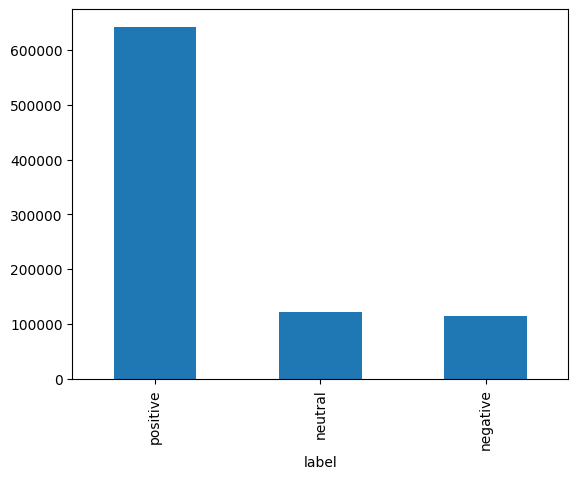

In [9]:
df_data['label'].value_counts().plot(kind='bar')

In [10]:
df_data['label'].value_counts()

label
positive    642046
neutral     122565
negative    113933
Name: count, dtype: int64

<Axes: ylabel='label'>

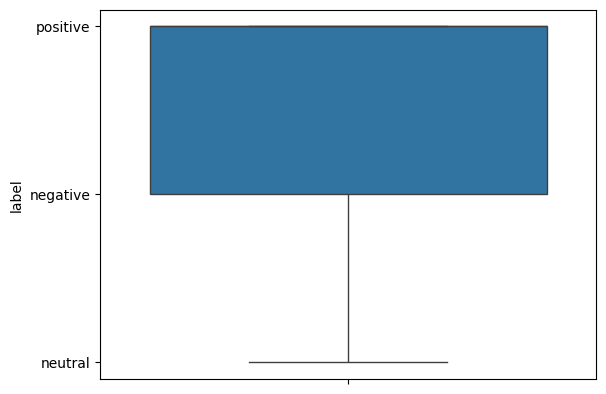

In [11]:
sns.boxplot(df_data['label'])

## Data Preprocessing

In [12]:
df_data.drop_duplicates(inplace=True)
df_data.duplicated().sum()

0

In [13]:
df_new = pd.DataFrame()
target_count = 53834

for rating, group in df_data.groupby('label'):
    if len(group) > target_count:
        ratings_new = resample(group, replace=False, n_samples=target_count, random_state=42)
    else:
        ratings_new = group
    df_new = pd.concat([df_new, ratings_new])

df_data = df_new.reset_index(drop=True)
df_data['label'].value_counts()

label
negative    53834
neutral     53834
positive    53834
Name: count, dtype: int64

In [14]:
df_data['text'] = df_data['title'] + ' ' + df_data['text']
df_data = df_data[['ratings_overall', 'text', 'label']]

In [15]:
def language_detection(text):
    try:
        return detect(text)
    except:
        return 'other'

In [16]:
df_data['language'] = df_data['text'].apply(language_detection)
df_data

,ratings_overall,text,label,language
0,2.0,“Near Airport with Good Shuttle Service” Staye...,negative,en
1,1.0,“Gets a low ranking for a reason...” I've few ...,negative,en
2,2.0,“Budget hotel pretending to be a resort” The H...,negative,en
3,1.0,“Dish out a few extra bucks and stay elsewhere...,negative,en
4,2.0,“L.A. on a budget” The Good: Lowest cost for a...,negative,en
...,...,...,...,...
161497,5.0,“Fantastic mid range hotel (u won't find bette...,positive,en
161498,4.0,“Fantastic Service” All the staff that I encou...,positive,en
161499,4.0,“A great find” We stayed here for a weekend. P...,positive,en
161500,4.0,“Convenient location for the airport” We staye...,positive,en


In [17]:
df_data = df_data[df_data['language'] == 'en']

In [18]:
def remove_punctuation(text):
    text = ''.join([char if char not in string.punctuation else ' ' for char in text]).lower()
    return text

In [19]:
def additional_cleaning(text):
    replacements = {
        'n t': 'not',
        'nt': 'not',
        'didn t': 'did not',
        'didn': 'did not',
        'don t': 'do not',
        'don': 'do not',
        'doesn t': 'does not',
        'doesn': 'does not',
        'hasn t': 'has not',
        'hasn': 'has not',
        'haven t': 'have not',
        'haven': 'have not',
        'hadn t': 'had not',
        'hadn': 'had not',
        'won t': 'will not',
        'won': 'will not',
        'wouldn t': 'would not',
        'wouldn': 'would not',
        'can t': 'can not',
        'can': 'can not',
        'couldn t': 'could not',
        'couldn': 'could not',
        'shouldn t': 'should not',
        'shouldn': 'should not',
        'aren t': 'are not',
        'aren': 'are not',
        'ain t': 'am not',
        'ain': 'am not',
        'isn t': 'is not',
        'isn': 'is not',
        'wasn t': 'was not',
        'wasn': 'was not',
        'were t': 'were not',
        'were': 'were not',
        'weren t': 'were not',
        'weren': 'were not',
        'what s': 'what is',
        'what': 'what is',
        'who s': 'who is',
        'who': 'who is',
        'where s': 'where is',
        'where': 'where is',
        'when s': 'when is',
        'when': 'when is',
        'why s': 'why is',
        'why': 'why is',
        'how s': 'how is',
        'how': 'how is',
        'll': 'will',
        've': 'have',
        're': 'are',
        'm': 'am',
        'em': 'them',
        'thats': 'that is',
        'that s': 'that is'
    }
    for old, new in replacements.items():
        text = re.sub(r'\b' + old + r'\b', new, text)

    text = re.sub(r'[^\x00-\x7F]+', '', text)

    return text

In [20]:
df_data['clean_punc'] = df_data['text'].apply(lambda x: remove_punctuation(x)).apply(lambda x: additional_cleaning(x))

C:\Users\ACER\AppData\Local\Temp\ipykernel_2212\3814134040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['clean_punc'] = df_data['text'].apply(lambda x: remove_punctuation(x)).apply(lambda x: additional_cleaning(x))


In [21]:
nlp = spacy.load('en_core_web_lg')

In [22]:
df_data.head()

,ratings_overall,text,label,language,clean_punc
0,2.0,“Near Airport with Good Shuttle Service” Staye...,negative,en,near airport with good shuttle service stayed ...
1,1.0,“Gets a low ranking for a reason...” I've few ...,negative,en,gets a low ranking for a reason i have few ...
2,2.0,“Budget hotel pretending to be a resort” The H...,negative,en,budget hotel pretending to be a resort the han...
3,1.0,“Dish out a few extra bucks and stay elsewhere...,negative,en,dish out a few extra bucks and stay elsewhere ...
4,2.0,“L.A. on a budget” The Good: Lowest cost for a...,negative,en,l a on a budget the good lowest cost for a b...


In [23]:
stopwords_list = stopwords.words('english')
def remove_stopwords(text):
    token_words = text.split()
    filtered_words = []
    for word in token_words:
        if word not in stopwords_list:
            filtered_words.append(word)
    return ' '.join(filtered_words)

In [24]:
def lemmatize_text(texts):
    lemmatized_texts = []
    for doc in nlp.pipe(texts, n_process=6,batch_size=1000):
        lemmatized_text = " ".join([token.lemma_ for token in doc])
        lemmatized_texts.append(lemmatized_text)
    return lemmatized_texts

In [25]:
def remove_token_with_word_and_number(text):
    words = text.split()
    filtered_words = []
    for word in words:
        if not any(char.isdigit() for char in word):
            filtered_words.append(word)
    return ' '.join(filtered_words)


In [26]:
def perform_ner(texts):
    replaced_texts = []
    for doc in nlp.pipe(texts, n_process=6, batch_size=1000):
        replaced_text = []
        for token in doc:
            if token.ent_type_:
                replaced_text.append(token.ent_type_)
            else:
                replaced_text.append(token.text)
        replaced_texts.append(' '.join(replaced_text))
    
    return replaced_texts

In [28]:
df_data['lemmatized_review'] = lemmatize_text(df_data['clean_punc'])
df_data['number_review'] = df_data['lemmatized_review'].apply(lambda x: remove_token_with_word_and_number(x))

C:\Users\ACER\AppData\Local\Temp\ipykernel_2212\2368988799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['lemmatized_review'] = lemmatize_text(df_data['clean_punc'])
C:\Users\ACER\AppData\Local\Temp\ipykernel_2212\2368988799.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['number_review'] = df_data['lemmatized_review'].apply(lambda x: remove_token_with_word_and_number(x))


In [29]:
df_data['ner_review'] = perform_ner(df_data['number_review'])

C:\Users\ACER\AppData\Local\Temp\ipykernel_2212\2839222559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['ner_review'] = perform_ner(df_data['number_review'])


In [30]:
print('Original Review:\t', df_data['text'][4])
print('Lemmatized Review:\t', df_data['lemmatized_review'][4])
print('Token Number Review:\t', df_data['number_review'][4])
print('Name Entity R Review:\t', df_data['ner_review'][4])

Original Review:	 “L.A. on a budget” The Good: Lowest cost for a branded hotel near downtown; very large selection of TV channels; refrigerator & iron with full-size board in room.
The Bad: Ants in room; no coffee or microwave in room; questionable neighborhood; ridiculously tiny space at sink-had to use refrigerator to hold shaver, toothbrush & a few other sundries; restaurant did not look appetizing & had very limited menu (did not use).
The Ugly: VERY noisy due to sound coming through PTAC; rod was compression style & kept falling; water flow at sink was nearly non-existent; breakfast was 2 cold cereals, tang, coffee, & an open loaf of bread for toast.
Lemmatized Review:	 l a   on a budget the good   low cost for a brand hotel near downtown   very large selection of tv channel   refrigerator    iron with full size board in room 
 the bad   ant in room   no coffee or microwave in room   questionable neighborhood   ridiculously tiny space at sink have to use refrigerator to hold shave

In [31]:
df_data.head()

,ratings_overall,text,label,language,clean_punc,lemmatized_review,number_review,ner_review
0,2.0,“Near Airport with Good Shuttle Service” Staye...,negative,en,near airport with good shuttle service stayed ...,near airport with good shuttle service stay he...,near airport with good shuttle service stay he...,near airport with good shuttle service stay he...
1,1.0,“Gets a low ranking for a reason...” I've few ...,negative,en,gets a low ranking for a reason i have few ...,get a low ranking for a reason I have few ...,get a low ranking for a reason I have few posi...,get a low ranking for a reason I have few posi...
2,2.0,“Budget hotel pretending to be a resort” The H...,negative,en,budget hotel pretending to be a resort the han...,budget hotel pretend to be a resort the hanale...,budget hotel pretend to be a resort the hanale...,budget hotel pretend to be a resort the hanale...
3,1.0,“Dish out a few extra bucks and stay elsewhere...,negative,en,dish out a few extra bucks and stay elsewhere ...,dish out a few extra buck and stay elsewhere t...,dish out a few extra buck and stay elsewhere t...,dish out a few extra buck and stay elsewhere t...
4,2.0,“L.A. on a budget” The Good: Lowest cost for a...,negative,en,l a on a budget the good lowest cost for a b...,l a on a budget the good low cost for a br...,l a on a budget the good low cost for a brand ...,l a on a budget the good low cost for a brand ...


In [32]:
df_data = df_data[['ner_review', 'ratings_overall', 'label']]
df_data.columns = ['text', 'rating', 'label']

In [34]:
df_data.to_csv('Data/data_2/clean_review_160k.csv', index=False)